In [2]:
%load_ext autoreload
%autoreload 1
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = [14, 10]


import torch
from torch.utils.data import Dataset
from retinanet.encoder import DataEncoder
import imgaug as ia
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np
from retinanet.retinanet import RetinaNet
from retinanet.loss import FocalLoss
from utils.pikachu_dataset import load_data_pikachu


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/i008/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:

class PikachuDataset(Dataset):
    def __init__(self, anchor_areas=None):
        
        self.anchor_areas = anchor_areas
        self.train, self.val = load_data_pikachu(1)
    
        encoder = DataEncoder()
        if self.anchor_areas is not None:
            encoder.anchor_areas = self.anchor_areas  # p3 -> p7
            
        self.encoder = encoder 
        
    def __len__(self):
        return 900 #magic number thats how many images are in the pikachu dataset
        
    def __getitem__(self, i):
        try:
            b = self.train.next()
        except StopIteration:
            self.train.reset()
            b = self.train.next()
            
        image = b.data[0].asnumpy()
        bbox = b.label[0].asnumpy()[:, 0, 1:] * 256
        label = b.label[0].asnumpy()[:, 0, 0]
    
        return torch.from_numpy(image), torch.from_numpy(bbox), torch.from_numpy(label)    
    
    def collate_func(self, batch):
    

        images = [b[0][0] for b in batch]
        bbox = [b[1] for b in batch]
        labels = [b[2] for b in batch]
        
        encoded = [self.encoder.encode(bb, l, torch.Tensor([256, 256])) for bb, l in zip(bbox, labels)]
        loc_target = [l[0] for l in encoded]
        cls_target = [l[1] for l in encoded]
        

        return torch.stack(images) / 255, torch.stack(loc_target), torch.stack(cls_target)
        
def init_weights_retina(module, pi=0.02):
    if hasattr(module, 'name'):
        b = -log((1 - pi) / pi)
        if module.name == 'final_layer':
            module.bias.data.fill_(b)
        elif module.name == 'head_layer':
            module.weight.data.normal_(0, pi)
            module.bias.data.fill_(0)
                        

In [4]:
pikachu_ds =PikachuDataset()
pikachu_dl = DataLoader(pikachu_ds, batch_size=8, collate_fn=pikachu_ds.collate_func)


In [4]:
device  = 'cuda' if torch.cuda.is_available() else 'cpu'

model = RetinaNet(1)
model = model.to(device)


model.freeze_bn()
for param in model.fpn.parameters():
    param.requires_grad = False
    

model.apply(init_weights_retina)

RetinaNet(
  (fpn): FPN(
    (encoder): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace)
          

In [39]:
criterion = FocalLoss(1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00004)

collect = []
for epoch in range(5):
    for b in pikachu_dl:
        optimizer.zero_grad()
        image, bounding_boxes, labels = b
        image = image.to(device)
        bounding_boxes = bounding_boxes.to(device)
        labels = labels.to(device)
        loc_pred, cls_pred = model(image)
        total_loss = criterion(loc_pred, bounding_boxes, cls_pred, labels)
        total_loss.backward()
        torch.nn.utils.clip_grad_norm(model.parameters(), 1)
        optimizer.step()
        collect.append([total_loss])
        print("total loss {}".format(total_loss))
        

/home/i008/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/i008/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/i008/anaconda3/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/i008/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:16: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn

cls loss 26.33708953857422  loc loss 5.699960708618164
total loss 32.03704833984375
cls loss 43.26380157470703  loc loss 4.861935615539551
total loss 48.125736236572266
cls loss 43.39344787597656  loc loss 5.6742262840271
total loss 49.06767272949219
cls loss 28.34850311279297  loc loss 5.840674877166748
total loss 34.189178466796875
cls loss 40.73854064941406  loc loss 7.785022258758545
total loss 48.523563385009766
cls loss 46.177066802978516  loc loss 6.809612274169922
total loss 52.98667907714844
cls loss 24.795808792114258  loc loss 4.808953762054443
total loss 29.60476303100586
cls loss 24.329978942871094  loc loss 4.51523494720459
total loss 28.84521484375
cls loss 39.13703536987305  loc loss 4.660472393035889
total loss 43.797508239746094
cls loss 37.61529541015625  loc loss 5.230952739715576
total loss 42.846248626708984
cls loss 34.677589416503906  loc loss 5.518052101135254
total loss 40.195640563964844
cls loss 50.04955291748047  loc loss 6.8353800773620605
total loss 56.88

cls loss 30.83670997619629  loc loss 3.197978973388672
total loss 34.034690856933594
cls loss 27.178016662597656  loc loss 3.1242048740386963
total loss 30.302221298217773
cls loss 24.575233459472656  loc loss 3.4610953330993652
total loss 28.03632926940918
cls loss 37.69416046142578  loc loss 5.895769119262695
total loss 43.589927673339844
cls loss 27.8907470703125  loc loss 3.416926145553589
total loss 31.30767250061035
cls loss 36.0643310546875  loc loss 6.031386375427246
total loss 42.09571838378906
cls loss 23.998565673828125  loc loss 4.000508785247803
total loss 27.999074935913086
cls loss 24.037452697753906  loc loss 4.02186918258667
total loss 28.059322357177734
cls loss 20.28830337524414  loc loss 5.106354236602783
total loss 25.394657135009766
cls loss 29.99783706665039  loc loss 3.709475517272949
total loss 33.707313537597656
cls loss 26.27846908569336  loc loss 6.0917510986328125
total loss 32.37022018432617
cls loss 30.14773178100586  loc loss 4.757996559143066
total loss

cls loss 30.532249450683594  loc loss 4.291348457336426
total loss 34.8235969543457
cls loss 28.887876510620117  loc loss 4.3762922286987305
total loss 33.26416778564453
cls loss 23.53462791442871  loc loss 4.286556243896484
total loss 27.821184158325195
cls loss 30.362083435058594  loc loss 4.465297698974609
total loss 34.8273811340332
cls loss 17.56541633605957  loc loss 3.467191696166992
total loss 21.032608032226562
cls loss 26.889894485473633  loc loss 4.336151599884033
total loss 31.226045608520508
cls loss 28.989543914794922  loc loss 5.383109092712402
total loss 34.37265396118164
cls loss 23.425416946411133  loc loss 4.180927753448486
total loss 27.60634422302246
cls loss 23.309316635131836  loc loss 4.449445724487305
total loss 27.75876235961914
cls loss 29.593299865722656  loc loss 4.4917378425598145
total loss 34.08503723144531
cls loss 22.223388671875  loc loss 3.4471230506896973
total loss 25.67051124572754
cls loss 21.107084274291992  loc loss 4.89710807800293
total loss 

cls loss 20.569509506225586  loc loss 3.3770365715026855
total loss 23.94654655456543
cls loss 23.42564582824707  loc loss 4.542627811431885
total loss 27.968273162841797
cls loss 22.780651092529297  loc loss 3.2493557929992676
total loss 26.030006408691406
cls loss 28.10041618347168  loc loss 3.549027681350708
total loss 31.649444580078125
cls loss 23.492530822753906  loc loss 2.9293177127838135
total loss 26.42184829711914
cls loss 25.742328643798828  loc loss 4.759031772613525
total loss 30.501359939575195
cls loss 16.419208526611328  loc loss 3.8205697536468506
total loss 20.239778518676758
cls loss 15.699851989746094  loc loss 3.640127658843994
total loss 19.33997917175293
cls loss 28.95632553100586  loc loss 6.520791053771973
total loss 35.477115631103516
cls loss 26.699148178100586  loc loss 4.494603633880615
total loss 31.19375228881836
cls loss 20.284217834472656  loc loss 4.766016960144043
total loss 25.050235748291016
cls loss 26.344348907470703  loc loss 4.127048969268799
t

cls loss 22.119544982910156  loc loss 3.1659045219421387
total loss 25.285449981689453
cls loss 28.678733825683594  loc loss 4.871945858001709
total loss 33.55067825317383
cls loss 24.34520721435547  loc loss 4.809385776519775
total loss 29.154592514038086
cls loss 19.154447555541992  loc loss 4.762012004852295
total loss 23.916460037231445
cls loss 25.788890838623047  loc loss 3.805262565612793
total loss 29.594154357910156
cls loss 26.883872985839844  loc loss 2.985812187194824
total loss 29.869686126708984
cls loss 23.314693450927734  loc loss 4.739297389984131
total loss 28.053991317749023
cls loss 17.978464126586914  loc loss 3.192875623703003
total loss 21.17133903503418
cls loss 21.74193572998047  loc loss 4.3913984298706055
total loss 26.13333511352539
cls loss 36.686614990234375  loc loss 6.36785364151001
total loss 43.05447006225586
cls loss 22.357524871826172  loc loss 4.9699225425720215
total loss 27.32744789123535
cls loss 18.832786560058594  loc loss 3.6526167392730713
to

cls loss 26.803245544433594  loc loss 7.490839004516602
total loss 34.29408264160156
cls loss 23.701826095581055  loc loss 4.79649019241333
total loss 28.498315811157227
cls loss 23.002117156982422  loc loss 3.7160518169403076
total loss 26.718168258666992
cls loss 29.839391708374023  loc loss 4.392985820770264
total loss 34.23237609863281
cls loss 22.263195037841797  loc loss 3.5448055267333984
total loss 25.808000564575195
cls loss 22.742141723632812  loc loss 3.9273791313171387
total loss 26.66952133178711
cls loss 21.257522583007812  loc loss 2.6103622913360596
total loss 23.86788558959961
cls loss 18.551342010498047  loc loss 3.576486587524414
total loss 22.12782859802246
cls loss 24.463571548461914  loc loss 3.872714042663574
total loss 28.336284637451172
cls loss 15.658537864685059  loc loss 3.8280603885650635
total loss 19.48659896850586
cls loss 24.477401733398438  loc loss 4.6906657218933105
total loss 29.168067932128906
cls loss 17.242168426513672  loc loss 4.487216949462891

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f082c2a4048>],
      dtype=object)

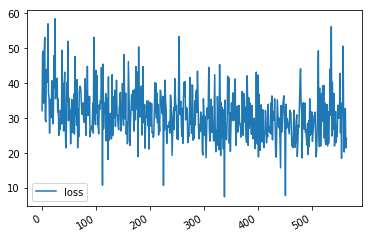

In [47]:
import pandas as pd
pd.DataFrame(collect, columns=['loss']).astype(float).plot(subplots=True)

# Visualizing Results

In [48]:
it = iter(pikachu_dl)


/home/i008/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/i008/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


failed in nnms


Text(0.5,1,'score 0.826163113117218')

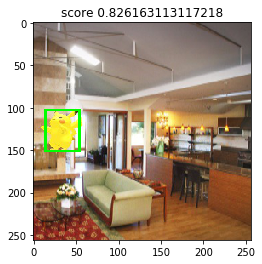

In [54]:
model.eval()
b = next(it)
i = 0
image, bounding_boxes, labels = b
loc_pred, cls_pred = model(image.cuda())


bbspred, labelpred, score  = pikachu_ds.encoder.decode(loc_pred[i].float().cpu(), 
                                                       cls_pred[i].float().cpu(), 
                                                       torch.Tensor([256, 256]).float().cpu()
                                                      )

image_to_show = np.moveaxis(image[i].detach().cpu().numpy(),0, 2)

matched_anchors_on_image = ia.BoundingBoxesOnImage(
    [ia.BoundingBox(*b) for b in bbspred.detach().cpu().numpy()], shape=(256, 256))


image_to_show = matched_anchors_on_image.draw_on_image(image_to_show, thickness=3)
plt.imshow(image_to_show)
plt.title('score ' + str(float(score)))

# Exercises

